In [1]:
import numpy as np
import os
import pandas as pd
import PIL
import PIL.Image
from tqdm import tqdm, tqdm_pandas
tqdm.pandas()
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import cv2
from IPython.display import Image, display, SVG
from IPython.display import Image
from IPython.core.display import HTML 

from keras.models import Sequential, Model
from keras.layers import Input, merge, Activation
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.callbacks import CSVLogger, ModelCheckpoint

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


##  1. Set up environment

- if you didn't manage, please group with someone who did
- you can still try at home and run the code after the workshop


## 2. What we'll do today

-	Udacity simulator
-	Jupyter notebooks
-	Docker
-   Neural networks



## 3. Let's see what we'll achieve by the end of the workshop

- open simulator in "Autonomous Mode" in the first track
- open "Drive Autonomous" notebook, and go to "Kernel" -> "Restart & Run All" 

## 4. Gather Training Data

1. **Create folder for images**
    - create a folder called "simulator_data" 
    
    
2. **Open simulator**
    - in "Training" mode
    - press the "record" button and select the **simulator_data** folder you just created
    - press record again
    - play 1 lap
    - stop the recording

## 5. **While we wait**

### Credits
1. **Udacity**
    - self driving car nanodegree: https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd013


2. **Siraj Raval**

    - channel: https://www.youtube.com/channel/UCWN3xxRkmTPmbKwht9FuE5A/videos
    - video: https://www.youtube.com/watch?v=EaY5QiZwSP4&t=948s
  

## 6. Let's get to work !!

### Information

Now that we have all the data already saved from the simulator, it's time to process it and train a model using it !
Just run the cells below in order to set the necessary paths

In [2]:
img_size = (75, 320)

In [3]:
data_path = "../../simulator_data/"

In [4]:
img_path = data_path + "IMG/"
csv_path = data_path + "driving_log.csv"

# Read CSV

### Information

We need to read the CSV file the Udacity Simulator has saved and process the information there. 

Try using the **read_csv** method shown below to read the CSV file containing the images information. Remember that the column names are:
1. center
2. left
3. right
4. steering
5. throttle
6. reverse
7. speed

Name your variable ***data_df***

### Code Example

You can read a csv file into a Pandas Dataframe using the function read_csv.

```python
df = pd.read_csv(PATH, names = [LIST_OF_COLUMN_NAMES)
```

In [5]:
#Your code here
data_df = pd.read_csv(csv_path,  names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/read_csv_answer.py)

Let's see how the data looks like:

In [6]:
print(data_df.shape)
data_df.head()

(4560, 7)


,center,left,right,steering,throttle,reverse,speed
0,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,/Users/bogdang/IMG/left_2017_09_30_21_47_22_11...,/Users/bogdang/IMG/right_2017_09_30_21_47_22_1...,0.0,1,0,7.938610
1,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,/Users/bogdang/IMG/left_2017_09_30_21_47_22_18...,/Users/bogdang/IMG/right_2017_09_30_21_47_22_1...,0.0,1,0,8.841239
2,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,/Users/bogdang/IMG/left_2017_09_30_21_47_22_25...,/Users/bogdang/IMG/right_2017_09_30_21_47_22_2...,0.0,1,0,9.737076
3,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,/Users/bogdang/IMG/left_2017_09_30_21_47_22_33...,/Users/bogdang/IMG/right_2017_09_30_21_47_22_3...,0.0,1,0,10.625890
4,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,/Users/bogdang/IMG/left_2017_09_30_21_47_22_41...,/Users/bogdang/IMG/right_2017_09_30_21_47_22_4...,-0.2,1,0,11.593890


# Keep columns of interest

### Information

We want to keep just the columns that are interesting to us, namely
1. **features columns** ( which contain the information that we will use to predict our target variable). These are
    * **center**
    * **left**
    * **right**
     
2. **label column** ( which contain the information we will want to predict ). It is
    * **steering**


### Code Example

This is how you can select just a subset of columns of a DataFrame and you can assign it to the original DataFrame variable

```python
df = df[LIST_OF_COLUMN_NAMES]
```

In [7]:
#Your code here
data_df = data_df[["center","left","right","steering"]]

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/keep_columns_of_interest_answer.py)

Let's see how the data looks like:

In [8]:
print(data_df.shape)
data_df.head()

(4560, 4)


,center,left,right,steering
0,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,/Users/bogdang/IMG/left_2017_09_30_21_47_22_11...,/Users/bogdang/IMG/right_2017_09_30_21_47_22_1...,0.0
1,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,/Users/bogdang/IMG/left_2017_09_30_21_47_22_18...,/Users/bogdang/IMG/right_2017_09_30_21_47_22_1...,0.0
2,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,/Users/bogdang/IMG/left_2017_09_30_21_47_22_25...,/Users/bogdang/IMG/right_2017_09_30_21_47_22_2...,0.0
3,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,/Users/bogdang/IMG/left_2017_09_30_21_47_22_33...,/Users/bogdang/IMG/right_2017_09_30_21_47_22_3...,0.0
4,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,/Users/bogdang/IMG/left_2017_09_30_21_47_22_41...,/Users/bogdang/IMG/right_2017_09_30_21_47_22_4...,-0.2


# Rearange columns

### Information

As you can see, there are 3 columns ("center", "left" and "right") which contain paths to images, taken from different angles of the car. For our purpose, it would be useful to take these columns and merge them into a single one, as we'll have more data to train on.

For this, we have provided a helping function **rearrange_columns**, as the task is non trivial. If you're curios, please look over it and try to understand what it does.

Call the function below like in the Code Example section and assign the result back to the same variable

### Provided code

In [9]:
def rearrange_columns(data_df):
    rearranged_df_list = []
    
    for col in ['center','left','right']:
        partial_df = data_df[[col] + ['steering']]
        
        partial_df = partial_df.rename(columns = {col:'img_path'})
        
        rearranged_df_list.append(partial_df)
        
    rearranged_df = pd.concat(rearranged_df_list)
    
    return rearranged_df


### Code Example

It is sufficient to call the provided function like to

```python
df = rearrange_columns(df)
```

In [10]:
#Your code here
data_df = rearrange_columns(data_df)

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/rearange_columns_answer.py)

Let's see how the data looks like:

In [11]:
print(data_df.shape)
data_df.head()

(13680, 2)


,img_path,steering
0,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,0.0
1,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,0.0
2,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,0.0
3,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,0.0
4,/Users/bogdang/IMG/center_2017_09_30_21_47_22_...,-0.2


As you can see in the shape of the new DataFrame , now we have 3 times more images ! That will be really useful later on

# Change relative img path

### Information

If you look in the CSV files, all the paths to the actual images are paths on your local machine !

Now, they are no use to us, because we are running the Jupyter Notebook within the Docker container you just created, and the container's filesystem is completely independent of the filesystem of the machine we are running it on.

But as you remember, we started the container passing the ***-v*** parameter

```
docker run -d --name clujai -it -p 8884:8888 -p 4567:4567 -v /data/bogdang/datasets/clujai/simulator_data:/clujai/dataset clujai/sdc-workshop
```

This parameter allows us to mount a local filesystem folder to one inside the container. We can take advantage of this in order to fix all the paths of the images, as the images folder is visible in the container due to the before mentioned mount operation

What we'll need to do is to apply a special ***path_convertion*** function to each path. Luckily the DataFrame API allows us to apply a certain function to each element of a certain column. We have provided the ***path_conversion*** function below and all you need to do is use it !

### Provided Code

In [12]:
def path_conversion(path):
    return data_path + "IMG/" + path.split(path_separator)[-1]

### Code Example

Here's how you can apply a function to a DataFrame column and assign the returned values back to the column itself:

```python
df.loc[:,COLUMN_NAME] = df.loc[:,COLUMN_NAME].apply(CUSTOM_FUNCTION_NAME)
```

### Small Detail

If your're on Windows, then your paths will use "\" as a separator, whereas if you're on a Unix based operating system ( MacOS, Linux, etc) then your paths will use "/" as a separator.

Please change the value of the ***path_separator*** variable accordingly. Either assign it "/" or "\" 

In [13]:
path_separator = "/"

In [14]:
#Your code here
data_df.loc[:,"img_path"] = data_df.loc[:,"img_path"].apply(path_conversion)

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/change_relative_img_path_answer.py)

Let's see how the data looks like:

In [15]:
print(data_df.shape)
data_df.head()

(13680, 2)


,img_path,steering
0,../../simulator_data/IMG/center_2017_09_30_21_...,0.0
1,../../simulator_data/IMG/center_2017_09_30_21_...,0.0
2,../../simulator_data/IMG/center_2017_09_30_21_...,0.0
3,../../simulator_data/IMG/center_2017_09_30_21_...,0.0
4,../../simulator_data/IMG/center_2017_09_30_21_...,-0.2


# Shuffle Data

### Information

When training any type of ML model, it is very important to ***shuffle*** your data. This can lead to a smoother learning process and yield superior results.

So let's do just that

### Code Example

We'll leverage the existing method from the [sklearn](path) module. We'll pass it a seed in order to get the same shuffling every time we run the code. This is important, otherwiese we might get different training results every time we run the code. This is obviously something undesirable/

```python
df = shuffle(df,random_state = 0)
```

Shuffle the data and assign it back to the same varible


In [16]:
#Your code here
data_df = shuffle(data_df,random_state = 0)

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/shuffle_answer.py)

Let's see how the data looks like:

In [17]:
print(data_df.shape)
data_df.head()

(13680, 2)


,img_path,steering
4454,../../simulator_data/IMG/left_2017_09_30_21_53...,0.0
4344,../../simulator_data/IMG/right_2017_09_30_21_5...,-0.2
3553,../../simulator_data/IMG/right_2017_09_30_21_5...,0.0
3778,../../simulator_data/IMG/right_2017_09_30_21_5...,0.0
2804,../../simulator_data/IMG/center_2017_09_30_21_...,0.0


# Read Images

### Information

Now we are ready to read the images themselves. We can use the DataFrame API's ***apply*** method again, in order to take a path and return the image. The single difference now is that we will create another column, named ***img***, instead of overwriting the same column.

We have provided some helper method here as well. Namely, you will need to use the ***read_img*** function

### Provided Code

In [18]:
def crop(img):
    return img[60:-25, :, :] 

def read_image(path):
    img = np.asarray(PIL.Image.open(path)) # read image with PIL then transform it into a NumPy arry
    img = crop(img) # cropping the image, as we are only interested in the road
    
    return img

### Code Example

As might take a while, it would be useful if we could have some kind of a progress bar. Luckily, there is a method named ***progress_apply*** which provided us with exactly that:

```python
df.loc[:,DST_COLUMN_NAME] = data_df.loc[:,SRC_COLUMN_NAME].progress_apply(CUSTOM_FUNCTION_NAME)
```


In [19]:
#Your code here
data_df.loc[:,'img'] = data_df.loc[:,'img_path'].progress_apply(read_image)


100%|██████████| 13680/13680 [00:39<00:00, 346.17it/s]


[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/read_images_answer.py)

Let's see how the data looks like:

In [20]:
print(data_df.shape)
data_df.head()

(13680, 3)


,img_path,steering,img
4454,../../simulator_data/IMG/left_2017_09_30_21_53...,0.0,"[[[17, 31, 34], [7, 21, 24], [16, 27, 31], [12..."
4344,../../simulator_data/IMG/right_2017_09_30_21_5...,-0.2,"[[[218, 194, 130], [215, 193, 133], [209, 192,..."
3553,../../simulator_data/IMG/right_2017_09_30_21_5...,0.0,"[[[209, 180, 124], [195, 164, 107], [193, 163,..."
3778,../../simulator_data/IMG/right_2017_09_30_21_5...,0.0,"[[[85, 63, 65], [74, 52, 54], [83, 63, 65], [7..."
2804,../../simulator_data/IMG/center_2017_09_30_21_...,0.0,"[[[116, 93, 62], [114, 91, 60], [113, 90, 59],..."


# Visualize

### Information

It's always useful to visualize your data in order to make sure that you're passing to the ML model exactly what you want. So let's do just that ! 

We have provided a helper function ***plot_data*** to which you need to pass your DataFrame and the number of images to display.

### Provided Code

In [21]:
def plot_data(data_df, nr_images):

    for _,row in  data_df.iloc[:nr_images].iterrows():

        plt.imshow(row['img'])
        plt.figure()

        plt.show()


### Code Example

No code example here. Just call the function with the right parameters

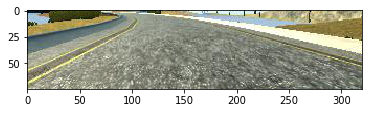

<Figure size 432x288 with 0 Axes>

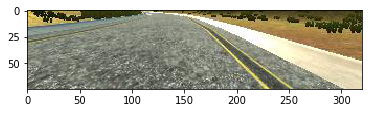

<Figure size 432x288 with 0 Axes>

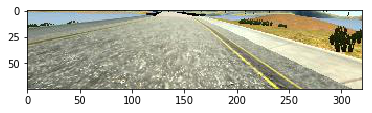

<Figure size 432x288 with 0 Axes>

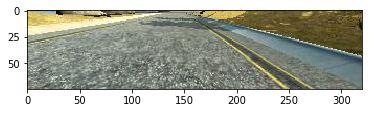

<Figure size 432x288 with 0 Axes>

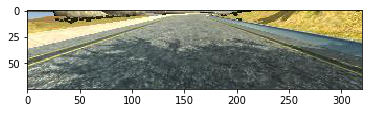

<Figure size 432x288 with 0 Axes>

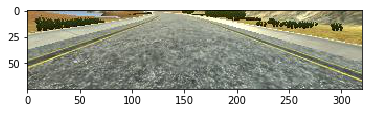

<Figure size 432x288 with 0 Axes>

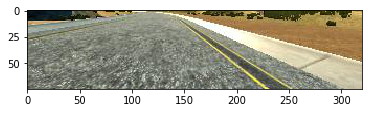

<Figure size 432x288 with 0 Axes>

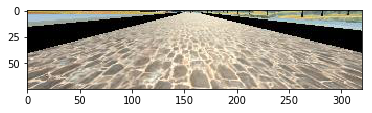

<Figure size 432x288 with 0 Axes>

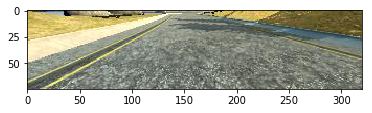

<Figure size 432x288 with 0 Axes>

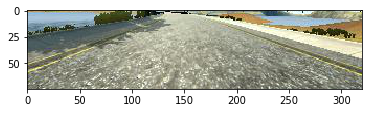

<Figure size 432x288 with 0 Axes>

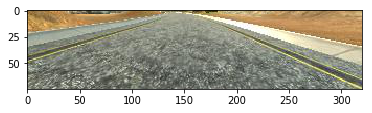

<Figure size 432x288 with 0 Axes>

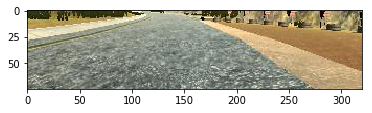

<Figure size 432x288 with 0 Axes>

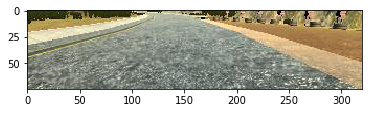

<Figure size 432x288 with 0 Axes>

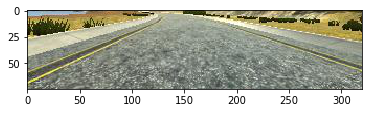

<Figure size 432x288 with 0 Axes>

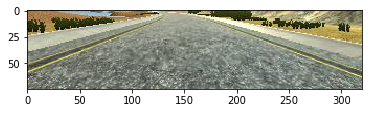

<Figure size 432x288 with 0 Axes>

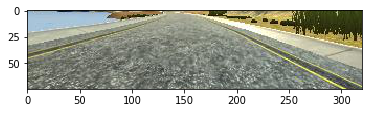

<Figure size 432x288 with 0 Axes>

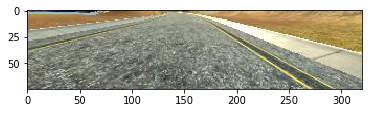

<Figure size 432x288 with 0 Axes>

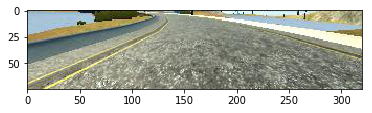

<Figure size 432x288 with 0 Axes>

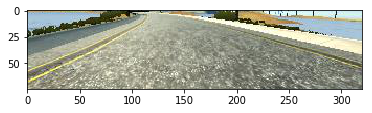

<Figure size 432x288 with 0 Axes>

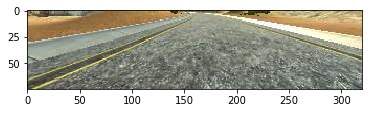

<Figure size 432x288 with 0 Axes>

In [22]:
# Your code here
plot_data(data_df, 20)

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/visualize_answer.py)

# Augment Data

### Information

In order to help our network perform the task we want it to perform, it would be useful to get as much data as possible. In our case, we could just manually play for a few more laps but for other image processing tasks, we might not have the luxury of being able to generate infinite training data

Therefore we could be inventive. One trick we could to would to be horizontally rotate the images while subsequently reverse it's corresponding steering value (because a left turn now suddenly becomes a right turn)

You will have to perform more steps at this point, but it will be worth it ! There is only 1 line of code that needs to be written for every step.

1. ***Step 1***
    * Create a copy of our DataFrame named ***augmented_df***. See how you can do this in the Code Example section
2. ***Step 2***
    * Reverse the images in the augmented_df using DataFrame API's apply method. You can apply the provided helper function named ***flip_image***. Do NOT create another column but instead overwrite the existing column.
3. ***Step 3***
    * Use the same technique in order to reverse the steering. We have provided a helper function for this as well named ***reverse_steering***. Do NOT create another column but instead overwrite the existing column.
4. ***Step 4***
    * Concatenate the original DataFrame with the augmented one and assign it back to the same variable. In the Code Example section you can see how this can be done.
5. ***Step 5***
    * After concatenation, you will have the the two DataFrames stacked one above the other. It would be best if we shuffle the resulting DataFrame again in order to mix the values up.

### Provided Code

In [23]:
def flip_image(img):
    return cv2.flip(img, 1)

def reverse_steering(s):
    return -s

### Code Example

One way to copy a DataFrame is by using the ***copy*** method from the DataFrame API.

```python
df_2 = df_1.copy()
```


Here's how you can concatenate two DataFrames and assign it to one of the variables again. We will use Pandas's ***concat*** method

```python
df_1 = pd.concat([df_1,df_2])
```


In [24]:
# Your code here
augmented_df = data_df.copy()
augmented_df.loc[:,'img'] = augmented_df.loc[:,'img'].apply(flip_image)
augmented_df.loc[:,'steering'] = augmented_df.loc[:,'steering'].apply(reverse_steering)
data_df = pd.concat([data_df,augmented_df])
data_df = shuffle(data_df,random_state = 0)

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/augment_answer.py)

Let's see how the data looks like:

In [25]:
data_df.shape

(27360, 3)

If everything went fine, you should now have 2 times more data !

# Visualize augmented data

### Information

Let's see how our augmented data looks like, just to make sure that everything went ok with our code. Use the ***plot_data*** method presented above, but this time pass the ***augmented_df***

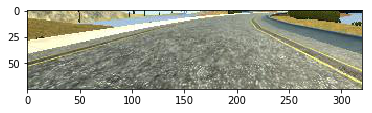

<Figure size 432x288 with 0 Axes>

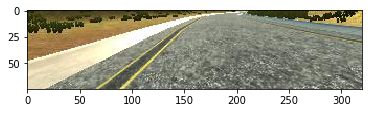

<Figure size 432x288 with 0 Axes>

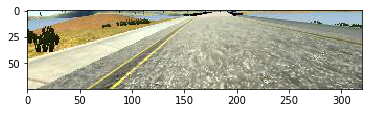

<Figure size 432x288 with 0 Axes>

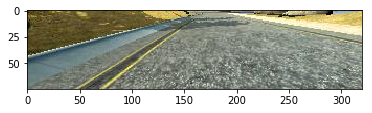

<Figure size 432x288 with 0 Axes>

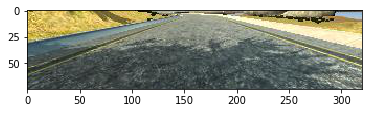

<Figure size 432x288 with 0 Axes>

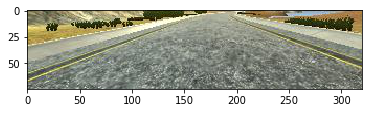

<Figure size 432x288 with 0 Axes>

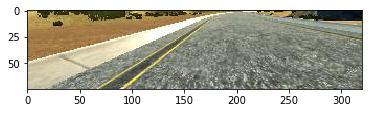

<Figure size 432x288 with 0 Axes>

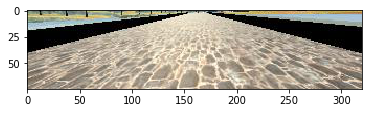

<Figure size 432x288 with 0 Axes>

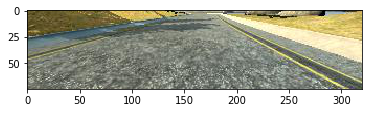

<Figure size 432x288 with 0 Axes>

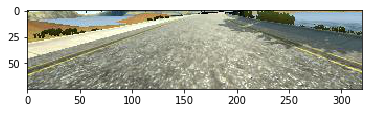

<Figure size 432x288 with 0 Axes>

In [26]:
#Your code here
plot_data(augmented_df,10)

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/visualize_augmented_answer.py)

# Split data in train / test datasets

### Information

Of course, we need to split the data in ***train dataset*** and ***test dataset***. 

Please choose a certain percentage to keep in your training set (we recommend somewhere between 0.65 and 0.85) and use the provided ***train_test_split*** method.

### Provided Code

In [27]:
def train_test_split(data_df, train_percentage):
    nr_train = int(train_percentage * len(data_df))
    train_df = data_df[:nr_train]
    test_df = data_df[nr_train:]
    
    return train_df, test_df

### Code Example

You can use the provided helper function like this:

```python
train_df, test_df = train_test_split(df, 0.8)
```

In [28]:
# Your code here
train_df, test_df = train_test_split(data_df, 0.8)

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/train_test_split_answer.py)

Let's see how the data looks like:

In [29]:
print(train_df.shape)
print(test_df.shape)

(21888, 3)
(5472, 3)


# Format data for model ingestion

### Information

Most (if not all) of Deep Learning frameworks written in Python expect data in the form of NumPy arrays. For those who are unfamiliar with it, NumPy is the de facto library to use for scientific computing in Python.

So far, we have used Pandas to manage our data, but now it is time to change it to NumPy. In each of our two DataFrames, we currently have two columns ***img*** which represent the features and ***steering*** which represents the label. Therefore we will need to convert each column into a NumPy Array.

Each NumPy array will have a different shape:

1. Features
    * On each DF row, we have an image having as shape (75,320,3) representing the height, width and number of color channels of each image
    * We will concatenate all the images in the DataFrame together by stacking them on top of each other. For example, if our DataFrame would have 100 images in it, we will end up with a NumPy array having the shape (100,75,320,3)
    
2. Label
    * On each DF row, we have a single integer
    * We will concatenate all the integers together. For example, if our DataFrame would have 100 values in it, we will end up with a NumPy array having the shape (100,)

So what you need to do is call the provided helper function called ***get_formated_data*** on both the training and the testing DataFrames and get their corresponding NumPy arrays.


### Provided Code

In [30]:
def get_formated_data(data_df):
    imgs = np.stack(data_df['img'].tolist())
    labels = np.stack(data_df['steering'].tolist())
    
    return imgs, labels


### Code Example

The way to use the provided helper function is 

```python
imgs_array, labels_array = get_formated_data(df)
```


In [31]:
# Your code here
train_imgs, train_labels = get_formated_data(train_df)
test_imgs, test_labels = get_formated_data(test_df)

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/format_data_answer.py)

Let's see how the data looks like:

In [32]:
print(train_imgs.shape)
print(train_labels.shape)

print(test_imgs.shape)
print(test_labels.shape)

(21888, 75, 320, 3)
(21888,)
(5472, 75, 320, 3)
(5472,)


# Model Creation

### Information

Now that we have created the data, it's time to create the model. If you look at the architecture of the model we're about to create in the ***get_model*** provided helper function, you'll notice a few things
1. We're treating this problem as a regression problem, aka trying to predict the continuous "steering" value
2. There is nothing fancy about this architecture. It's a classic mix of Convolutional Layers followed by Batch Normalization Layers and then some Dense (fully connected) ones. 

### Conv Layers

In [33]:
Image(url= "https://image.slidesharecdn.com/case-study-of-cnn-160501201532/95/case-study-of-convolutional-neural-network-3-638.jpg?cb=1462133741")

### Batch Normalization Layers

***What it does***

Normalizes the values at each layer

***Advantages***
1. Speeds up training
2. Reduces overfitting

In [34]:
Image(url= "https://r2rt.com/static/images/BN_output_23_0.png")

### Dropout Layer

***What it does***


***Advantages***
1. Reduces overfitting

In [35]:
Image(url= "https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_5/dropout.jpeg")

### ELU Nonlinearity

***Paper*** : https://arxiv.org/abs/1511.07289

In [36]:
Image(url= "https://machinelearningonlinedotblog.files.wordpress.com/2017/06/relu-and-elu.png?w=739")

### (Fun Fact) Why you should never use Sigmoid as your activation function

In [37]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*XxxiA0jJvPrHEJHD4z893g.png")

One of the main reasons why you never want your sigmoid as your activation function is because the gradients can very easily vanish. The reason for that is very simple:

When the sigmoid has very high/low values, the derivative in that points is very close to 0, which means that the gradient is close to 0 (aka vanishes) and your weights don't get updated anymore

In [38]:
Image(url= "http://ronny.rest/media/blog/2017/2017_08_10_sigmoid/sigmoid_and_derivative_plot.jpg")

### Provided code

As you can see, defining a model architecture in Keras is really simple and straightforward. You just create a **Sequential** model and then you add layers to it. After that, you define the loss function, in our case it will be "mean_squared_error" and the optimizer, for which we chose Adam.

The network chosen has been initially presented here https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/

In [39]:
def get_model():
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape= img_size + (3,), output_shape = img_size + (3,)))
    model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
    model.add(BatchNormalization(axis=1))
    
    model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
    model.add(BatchNormalization(axis=1))
    
    model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
    model.add(BatchNormalization(axis=1))
    
    model.add(Conv2D(64, (5, 5), activation='elu'))
    model.add(BatchNormalization(axis=1))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001))
    
    return model

### Code Example

In order to create the model, just call

```python
model = get_model()
```

In [40]:
#Your code here
model = get_model()

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/model_answer.py)

We can inspect using the **summary** function, which prints the layers

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 158, 24)       1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 158, 24)       144       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 77, 36)        21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 77, 36)        64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 37, 48)         24        
__________

# Model Training

### Information

We are ready now to train our neural network. You just need to use the ***fit*** function like in the coding example, and you're good to go.

### Code Example

In order to call the ***fit*** function you need to pass a few simple parameters

```python
    model.fit( TRAIN_IMAGES, 
               TRAIN_LABELS,
               nb_epoch = NR_EPOCHS_TO_TRAIN_FOR,               
               validation_data = (TEST_IMAGES, TEST_LABELS),
               callbacks = [ ModelCheckpoint("./model_temp.h5", monitor='val_loss', verbose= 1, save_best_only=True, mode='min')
                 ]
      )
```
Here's what they mean:
1. TRAIN_IMAGES is the NumPy array consisting of training images you have just created
2. TRAIN_LABELS is the NumPy array consisting of training labels you have just created
3. NR_EPOCHS_TO_TRAIN_FOR is the number of epochs for which you wish to train the model
4. TEST_IMAGES is the NumPy array consisting of test images you have just created
5. TEST_LABELS is the NumPy array consisting of test labels you have just created

The callback at the end ***ModelCheckpoint*** will make sure to save at the path specified the best model from all the epochs


In [43]:
# Your code here
model.fit(train_imgs, train_labels,
      epochs= 5,               
      validation_data = (test_imgs, test_labels),
      callbacks = [ ModelCheckpoint("./model_temp.h5", monitor='val_loss', verbose= 1, save_best_only=True, mode='min')
                 ]
      )

Train on 21888 samples, validate on 5472 samples
Epoch 1/5
21888/21888 [==============================] - 25s 1ms/step - loss: 0.0899 - val_loss: 0.0231
Epoch 2/5
21888/21888 [==============================] - 25s 1ms/step - loss: 0.0680 - val_loss: 0.0230
Epoch 3/5
21888/21888 [==============================] - 25s 1ms/step - loss: 0.0582 - val_loss: 0.0242
Epoch 4/5
21888/21888 [==============================] - 25s 1ms/step - loss: 0.0494 - val_loss: 0.0234
Epoch 5/5
21888/21888 [==============================] - 25s 1ms/step - loss: 0.0471 - val_loss: 0.0231


[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/model_training_answer.py)

# Save best weights 

### Information

What we want now is to load the best weights from whatever epoch happened to yield the best results and save them at another location, such that we won't risk of overriding them when running another training

### Code Example

We have already provided code for loading the weights. Please use the ***save_weights*** method to save them at another location of your choosing. For simplicity, chose a relative path relative to the current directory such as ***./my_weights.h5***

```python
model.save_weights("./my_model.h5")
```

Don't forget to add the ***.h5*** extension at the end !


In [44]:
model.load_weights("./model_temp.h5")

In [45]:
# Your code here
model.save_weights("./my_best_weights.h5")

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/weights_save_answer.py)

# Save Model architecture

### Information

We're going to use these weights in another Jupyter Notebook in which we'll comunicate with the Self-Driving Car Simulator. The only thing that we need to do is to save the network's architecture to a file, such that we don't have to reconstruct it programatically again. 

We have provided the ***save_model_to_json*** helper method which is basically just a wraper over Keras's ***model.to_json()***


### Provided Code

In [46]:
def save_model_to_json(model, json_path):
    model_json = model.to_json()
    with open(json_path, "w") as json_file:
        json_file.write(model_json)

### Code Example

You just have to call the method decribed above and pass it the trained model and the json path

```python
save_model_to_json(MODEL, JSON_PATH)
```

In [47]:
# Your code here
save_model_to_json(model, "./model_architecture.json")

[Answer](https://github.com/Gliganu/clujAI-self-driving-car-workshop/blob/master/answers/json_save_answer.py)

# Finish

### Congratulations

You have successfully trained a Self-Driving Car Neural Network. Time to test it on the track and see how it performs. 

In order to do this, please open the Jupyter Notebook called "Drive-Autonomous.ipynb"